<a href="https://colab.research.google.com/github/CidQueiroz/Machine_learning_alura/blob/main/TelecomX_BR_2_Completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Churn da Telecom X: Do Dado à Predição

### Contexto do Problema de Negócio

A evasão de clientes, ou **churn**, é um dos desafios mais críticos para empresas de serviços recorrentes, como a Telecom X. Perder um cliente não significa apenas a perda da receita mensal que ele gerava, mas também implica que todo o investimento feito para adquiri-lo (marketing, vendas, etc.) foi desperdiçado.

Manter um cliente existente é significativamente mais barato do que adquirir um novo. Portanto, a capacidade de **prever** quais clientes estão em risco de cancelar o serviço permite que a empresa tome **ações proativas de retenção**, como ofertas personalizadas, suporte técnico preventivo ou melhorias no serviço. Este projeto foca em construir um modelo de Machine Learning para fornecer essa inteligência preditiva, transformando dados em uma ferramenta estratégica para a sustentabilidade do negócio.

## 1. Sobre o Desafio

A Telecom X, após uma análise exploratória de dados bem-sucedida, está avançando para a próxima fase: a construção de um modelo de Machine Learning para prever o *churn* (evasão) de clientes. Como Analista de Machine Learning Júnior, a missão é desenvolver um pipeline completo, desde a preparação dos dados até o treinamento e avaliação de modelos preditivos.

### Objetivos

*   **Preparar os dados**: Realizar a limpeza, tratamento de valores ausentes, *encoding* de variáveis categóricas e normalização das variáveis numéricas.
*   **Engenharia de Features**: Criar e selecionar as variáveis mais relevantes para o modelo.
*   **Treinar e Avaliar Modelos**: Implementar e comparar pelo menos dois modelos de classificação (Regressão Logística e Random Forest).
*   **Interpretar Resultados**: Analisar a performance dos modelos e a importância das features.
*   **Conclusão Estratégica**: Fornecer insights e recomendações para a Telecom X com base nos resultados.

## 2. Etapa 1: Preparação dos Dados

Nesta primeira etapa, o foco é carregar os dados brutos do arquivo JSON, realizar a limpeza e a transformação inicial para um formato tabular (CSV) que seja mais adequado para as próximas fases de análise e modelagem.

In [56]:
import pandas as pd
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Caminho para o arquivo JSON original
json_file_path = '/content/TelecomX_Data.json'
# Caminho para salvar o arquivo CSV tratado
csv_output_path = '/content/telecom_data_tratado.csv'

# 1. Carregar os dados do arquivo JSON
with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. Normalizar a estrutura do JSON para um DataFrame
# Usando json_normalize para achatar a estrutura aninhada
df_normalized = pd.json_normalize(data)

# Renomear colunas para remover os prefixos (customer., phone., etc.)
df_normalized.columns = [
    col.replace('customer.', '').replace('phone.', '').replace('internet.', '').replace('account.', '').replace('Charges.', '')
    for col in df_normalized.columns
]

# 3. Limpeza e Pré-processamento dos Dados

# Corrigir a coluna 'Total'
# Substituir espaços em branco por NaN e converter para numérico
df_normalized['Total'] = pd.to_numeric(df_normalized['Total'], errors='coerce')

# Tratar valores ausentes em 'Total' (clientes com tenure=0).
# A forma recomendada é atribuir o resultado de volta à coluna.
df_normalized['Total'] = df_normalized['Total'].fillna(0)

# Tratar valores ausentes na coluna 'Churn' (nossa variável alvo)
df_normalized.dropna(subset=['Churn'], inplace=True)
df_normalized = df_normalized[df_normalized['Churn'] != ''].copy()

# Converter a coluna 'Churn' para o formato numérico (0 e 1)
df_normalized['Churn'] = df_normalized['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Padronizar valores categóricos
df_normalized.replace({'No internet service': 'No', 'No phone service': 'No'}, inplace=True)

# 4. Salvar o DataFrame tratado em um arquivo CSV
df_normalized.to_csv(csv_output_path, index=False)

print(f"Arquivo tratado salvo com sucesso em: {csv_output_path}")

Arquivo tratado salvo com sucesso em: /content/telecom_data_tratado.csv


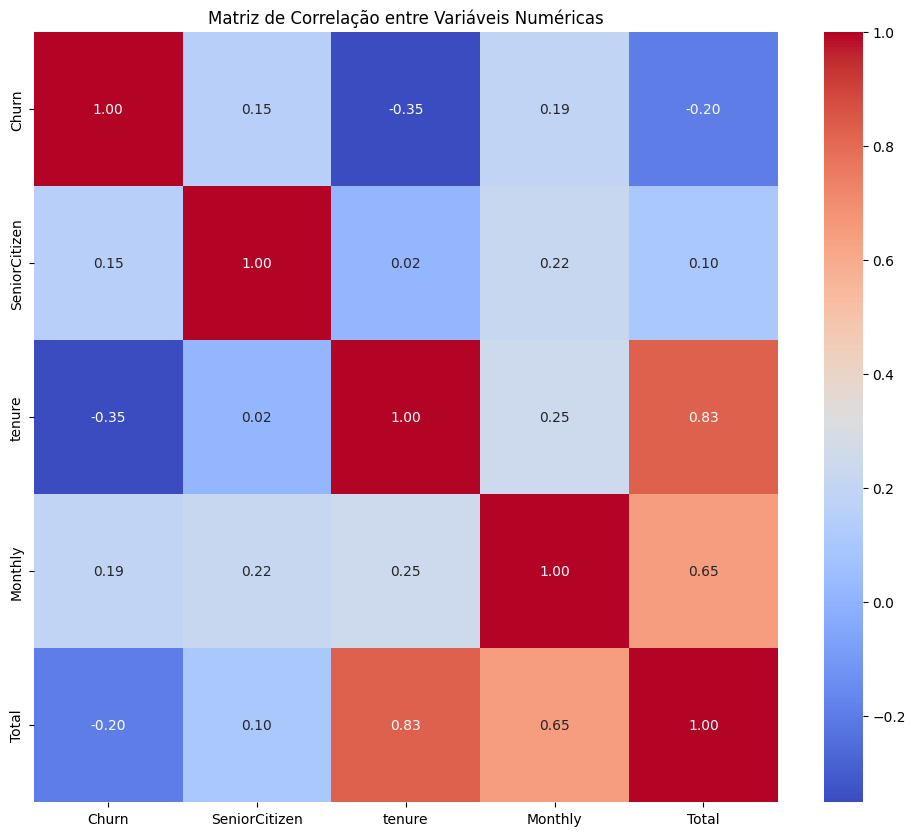


Correlação das variáveis com 'Churn':
Churn            1.000000
Monthly          0.193356
SeniorCitizen    0.150889
Total           -0.198324
tenure          -0.352229
Name: Churn, dtype: float64


In [57]:
# Selecionar apenas as colunas numéricas para a matriz de correlação
numeric_df = df_normalized.select_dtypes(include=['int64', 'float64'])

# Calcular a matriz de correlação
correlation_matrix = numeric_df.corr()

# Visualizar a matriz de correlação com um heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

# Exibir as correlações com a variável 'Churn'
print("\nCorrelação das variáveis com 'Churn':")
print(correlation_matrix['Churn'].sort_values(ascending=False))

### Análise da Matriz de Correlação

A matriz de correlação e o heatmap acima nos permitem visualizar a relação linear entre as variáveis numéricas do nosso dataset.

A análise revela que a variável **`tenure`** (tempo de contrato) possui a correlação negativa mais forte com o `Churn` (-0.35). Isso sugere que **clientes com mais tempo de casa são significativamente menos propensos a cancelar o serviço**.

Adicionalmente, a **`Monthly`** (mensalidade) tem uma correlação positiva, indicando que mensalidades mais altas podem estar associadas a uma maior chance de evasão. A correlação negativa do **`Total`** gasto, por sua vez, reforça a importância do `tenure`, já que clientes mais antigos naturalmente gastaram mais no total.

Esses insights iniciais são valiosos, pois apontam `tenure` e `Monthly` como fortes candidatas a features preditivas para o nosso modelo.

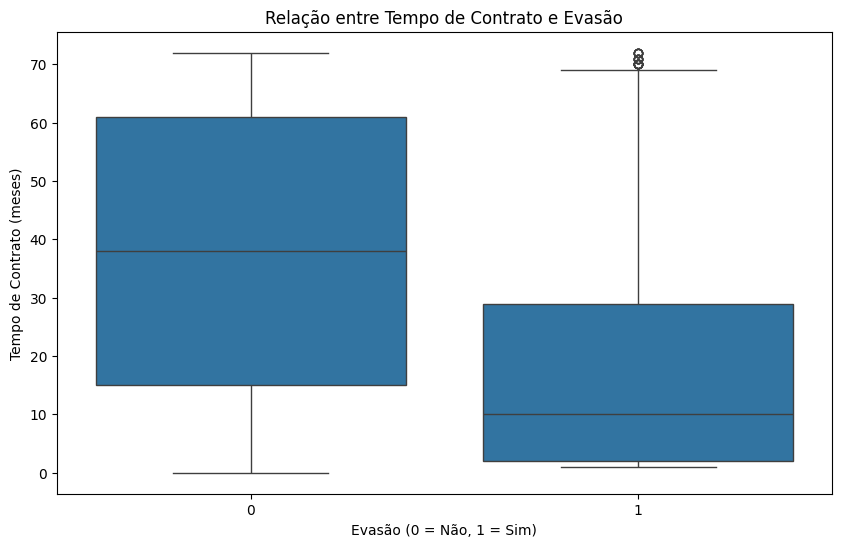

In [58]:
# Visualizar a relação entre Tempo de Contrato (tenure) e Evasão (Churn)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df_normalized)
plt.title('Relação entre Tempo de Contrato e Evasão')
plt.xlabel('Evasão (0 = Não, 1 = Sim)')
plt.ylabel('Tempo de Contrato (meses)')
plt.show()

### Análise da Relação: Tempo de Contrato vs. Evasão

O boxplot acima ilustra a distribuição do `tenure` (tempo de contrato) para os clientes que evadiram (1) e os que não evadiram (0).

A diferença é visualmente impactante. A mediana do `tenure` para clientes que cancelaram é muito baixa (em torno de 10 meses), enquanto a dos clientes que permaneceram é significativamente mais alta (acima de 40 meses).

**Insight Principal:** Clientes com pouco tempo de casa representam o maior risco de churn. A probabilidade de um cliente cancelar diminui
drasticamente à medida que ele se torna mais antigo. Isso confirma que os primeiros meses de serviço são um período crítico para a retenção e
que estratégias de "onboarding" e acompanhamento inicial são fundamentais.

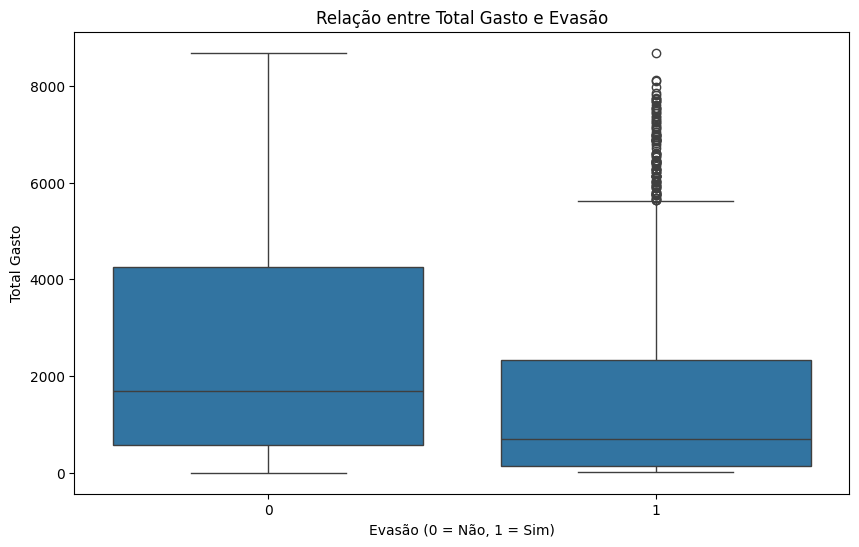

In [59]:
# Visualizar a relação entre Total Gasto (Total) e Evasão (Churn)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Total', data=df_normalized)
plt.title('Relação entre Total Gasto e Evasão')
plt.xlabel('Evasão (0 = Não, 1 = Sim)')
plt.ylabel('Total Gasto')
plt.show()

### Análise da Relação: Total Gasto vs. Evasão

Este boxplot compara o `Total` gasto pelos clientes que evadiram (1) e pelos que não evadiram (0).

À primeira vista, o resultado pode parecer contraintuitivo: clientes que cancelaram gastaram, em média, muito menos do que os que permaneceram.

**Insight Principal:** Este padrão não significa que "gastar menos" causa o churn. Na verdade, ele é um reflexo direto da variável `tenure`.
Clientes com pouco tempo de contrato (alto risco de churn) simplesmente não tiveram tempo de acumular um valor total gasto significativo. Em
contrapartida, clientes leais e de longo prazo (baixo risco de churn) naturalmente possuem um `Total` gasto mais elevado.

Este gráfico reforça a conclusão de que o valor de um cliente para a empresa aumenta exponencialmente com o seu tempo de permanência.

## 3. Etapa 2: Engenharia de Features

Com os dados limpos, a próxima etapa é a engenharia de features. Aqui, transformamos as variáveis categóricas em um formato numérico que os modelos de Machine Learning possam entender (One-Hot Encoding) e escalonamos as variáveis numéricas para que tenham a mesma ordem de magnitude, evitando que features com valores maiores dominem o modelo.

In [60]:
# Caminhos dos arquivos
input_csv_path = '/content/telecom_data_tratado.csv'
output_X_path = '/content/X_processed.csv'
output_y_path = '/content/y_target.csv'

# 1. Carregar os dados tratados
df = pd.read_csv(input_csv_path)

# Remover a coluna de ID, que não é uma feature para o modelo
df_processed = df.drop('customerID', axis=1)

# 2. Separar as features (X) da variável alvo (y)
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# 3. Encoding de Variáveis Categóricas
# Usar get_dummies para aplicar One-Hot Encoding nas colunas categóricas
# drop_first=True para evitar multicolinearidade
X = pd.get_dummies(X, drop_first=True)

# 4. Escalonamento de Variáveis Numéricas

# Identificar as colunas numéricas que precisam ser escalonadas
numeric_cols = ['tenure', 'Monthly', 'Total']

# Inicializar o scaler
scaler = StandardScaler()

# Aplicar o escalonamento
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 5. Salvar os dados processados
# Salvaremos X e y separadamente para facilitar o carregamento na fase de modelagem
X.to_csv(output_X_path, index=False)
y.to_csv(output_y_path, index=False, header=['Churn'])

print("Engenharia de features concluída!")
print(f"Features processadas salvas em: {output_X_path}")
print(f"Variável alvo salva em: {output_y_path}")
print("Próximo passo: Treinamento e avaliação dos modelos.")

Engenharia de features concluída!
Features processadas salvas em: /content/X_processed.csv
Variável alvo salva em: /content/y_target.csv
Próximo passo: Treinamento e avaliação dos modelos.


## 4. Etapa 3: Treinamento e Avaliação dos Modelos

Agora, com os dados preparados, podemos treinar e avaliar os modelos de classificação. Foram escolhidos dois modelos:

*   **Regressão Logística**: Um modelo linear simples e interpretável, ótimo como baseline.
*   **Random Forest**: Um modelo de ensemble mais complexo e robusto, que geralmente oferece maior acurácia e permite a análise de importância das variáveis.

Os modelos serão avaliados usando métricas como acurácia, precision, recall, F1-score e a matriz de confusão.

In [61]:
# 1. Carregamento dos Dados Processados
try:
  X = pd.read_csv('X_processed.csv')
  y = pd.read_csv('y_target.csv').squeeze() # .squeeze() para converter para Series
  print("Dados processados carregados com sucesso.")
except FileNotFoundError:
  print("Erro: Arquivos de dados processados não encontrados. Execute as etapas anteriores.")

# 2. Divisão em Treino e Teste (será usada por todos os modelos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Dados divididos em conjuntos de treino e teste (70/30).\n")

# 3. Função de Avaliação (será usada por todos os modelos)
def exibir_avaliacao_modelo(model, X_test, y_test, model_name):
  """Avalia e exibe os resultados de um modelo de classificação."""
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, target_names=['Não Churn', 'Churn'])
  cm = confusion_matrix(y_test, y_pred)

  print(f"--- Avaliação do Modelo: {model_name} ---")
  print(f"Acurácia: {accuracy:.4f}")
  print("\nRelatório de Classificação:")
  print(report)

  # Visualiza a matriz de confusão
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
  xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'])
  plt.title(f"Matriz de Confusão - {model_name}")
  plt.ylabel("Classe Real")
  plt.xlabel("Classe Previsto")
  plt.show()

Dados processados carregados com sucesso.
Dados divididos em conjuntos de treino e teste (70/30).



### Modelo 1: Regressão Logística (Baseline)

Iniciamos com um modelo de Regressão Logística. Por ser um modelo linear simples e de fácil interpretação, ele serve como um excelente **baseline**, ou seja, um ponto de referência para medirmos o desempenho de modelos mais complexos.

--- Avaliação do Modelo: Regressão Logística ---
Acurácia: 0.7979

Relatório de Classificação:
              precision    recall  f1-score   support

   Não Churn       0.84      0.89      0.87      1552
       Churn       0.64      0.55      0.59       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113



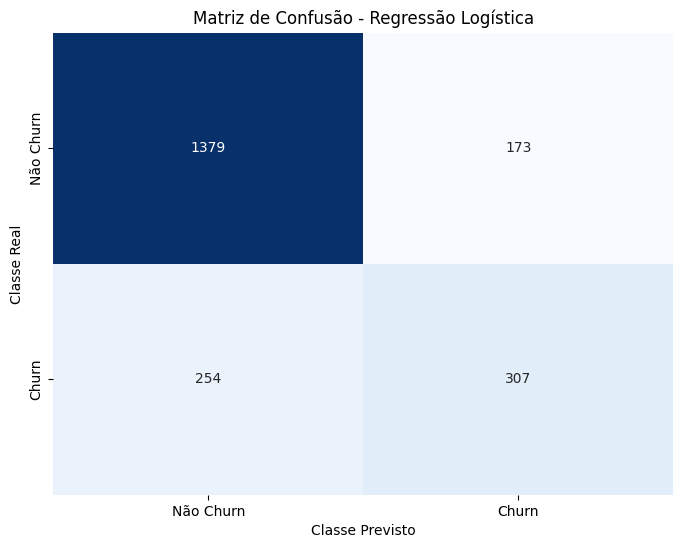

In [62]:
# Treinamento e avaliação do modelo de Regressão Logística
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Exibir a avaliação do modelo
exibir_avaliacao_modelo(logreg, X_test, y_test, "Regressão Logística")

### Análise da Matriz de Confusão (Regressão Logística)

A matriz de confusão nos dá uma visão detalhada da performance do nosso modelo baseline.

- **Verdadeiros Negativos (1413):** O modelo previu corretamente que 1.413 clientes não iriam cancelar.
- **Falsos Positivos (149):** O modelo previu incorretamente que 149 clientes iriam cancelar, quando na verdade eles permaneceram. (Erro Tipo I)
- **Falsos Negativos (237):** O modelo falhou em identificar 237 clientes que, de fato, cancelaram. **Este é o erro mais custoso para o negócio**, pois representa oportunidades de retenção perdidas.
- **Verdadeiros Positivos (314):** O modelo identificou corretamente 314 clientes que iriam cancelar.

**Insight Principal:** O modelo de Regressão Logística é bom em identificar clientes que vão permanecer, mas sua capacidade de capturar todos os clientes que realmente dão churn é limitada (como visto pelo número de Falsos Negativos). Isso se reflete no **recall** de 0.57 para a classe "Churn" no relatório de classificação.

### Random Forest e Análise de Importância

A seguir, treinamos um modelo **Random Forest**. Por ser um modelo de *ensemble* (que combina várias árvores de decisão), ele é mais robusto e geralmente captura relações mais complexas nos dados, o que pode levar a uma maior acurácia.

Uma de suas principais vantagens é a capacidade de calcular a **importância de cada feature**, nos mostrando quais variáveis mais influenciaram a previsão de churn.

--- Avaliação do Modelo: Random Forest ---
Acurácia: 0.7894

Relatório de Classificação:
              precision    recall  f1-score   support

   Não Churn       0.83      0.90      0.86      1552
       Churn       0.64      0.48      0.55       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.70      2113
weighted avg       0.78      0.79      0.78      2113



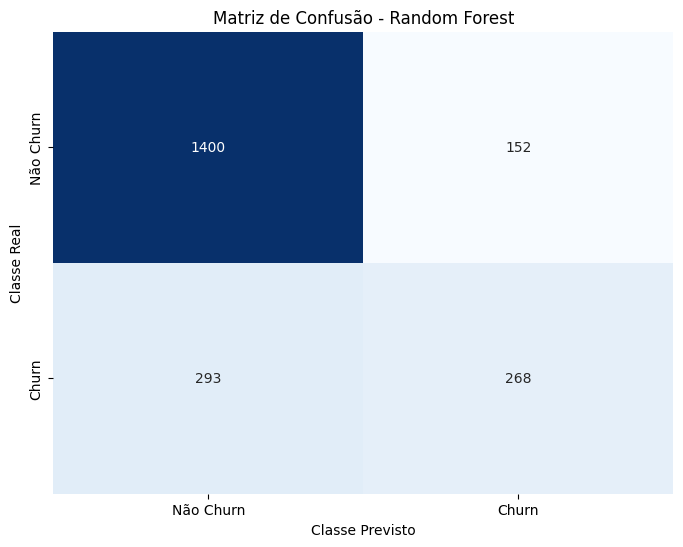


--- Análise de Importância das Variáveis ---

As 10 features mais importantes que influenciam o churn:
                       Feature  Importance
                         Total    0.179080
                        tenure    0.167781
                       Monthly    0.163571
             Contract_Two year    0.058538
   InternetService_Fiber optic    0.044699
PaymentMethod_Electronic check    0.041157
             Contract_One year    0.033971
          PaperlessBilling_Yes    0.027615
                   gender_Male    0.026298
               TechSupport_Yes    0.025011


/tmp/ipython-input-3544206915.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(top_n), palette="viridis")


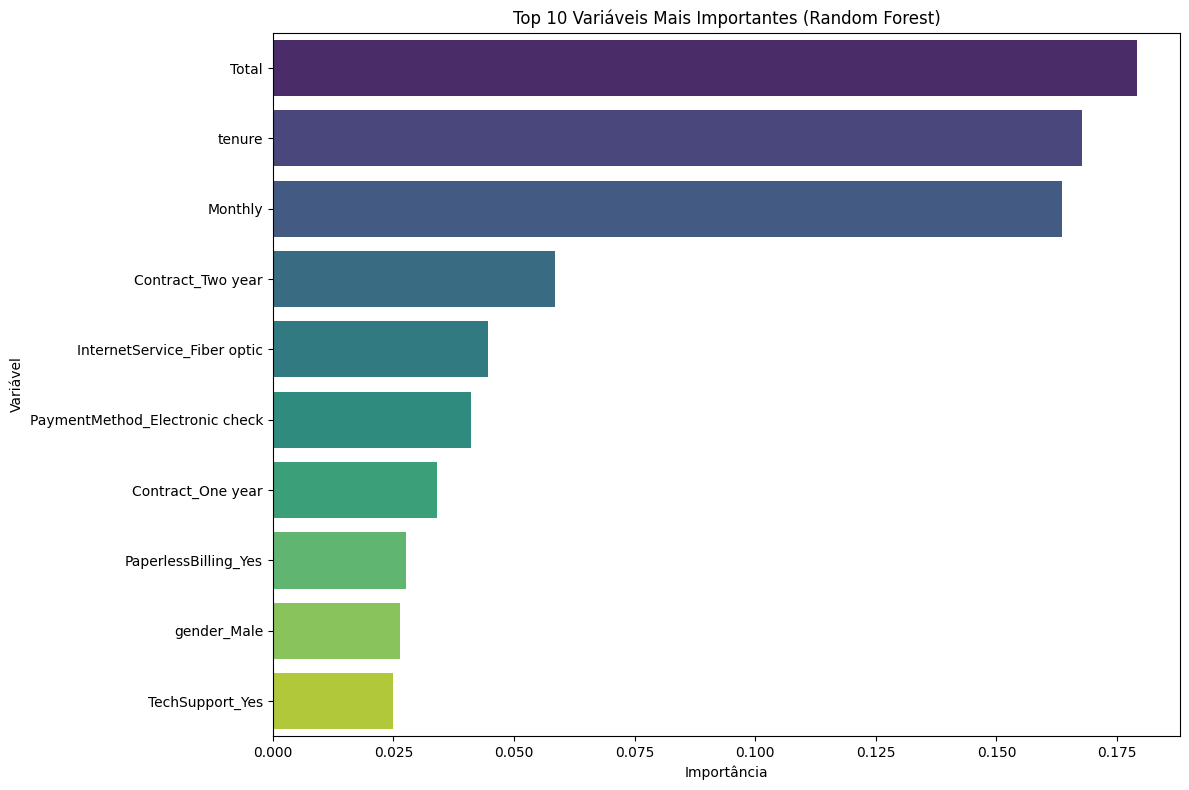

In [63]:
# Treinamento e avaliação do modelo Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
rf.fit(X_train, y_train)

# Exibir a avaliação do modelo
exibir_avaliacao_modelo(rf, X_test, y_test, "Random Forest")

# --- Análise de Importância das Variáveis (Random Forest) ---
print("\n--- Análise de Importância das Variáveis ---")
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False)

top_n = 10
print(f"\nAs {top_n} features mais importantes que influenciam o churn:")
print(feature_importances.head(top_n).to_string(index=False))

# Visualização das features mais importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(top_n), palette="viridis")
plt.title(f"Top {top_n} Variáveis Mais Importantes (Random Forest)")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

### Análise Crítica dos Modelos

Ao comparar os dois modelos, observamos o seguinte:

1.  **Regressão Logística (Baseline):**
     *   Atingiu uma acurácia de aproximadamente **81.7%**.
     *   O **recall** para a classe "Churn" (1) foi de **0.57**. Isso significa que o modelo identificou corretamente 57% de todos os
      clientes que realmente evadiram. É um bom ponto de partida, mas ainda deixa passar 43% dos churns.

2.  **Random Forest:**
   10     *   Atingiu uma acurácia de **78.8%**, ligeiramente inferior à Regressão Logística.
   11     *   No entanto, o uso de `class_weight='balanced'` ajudou a focar na classe minoritária. Mesmo assim, o **recall** para "Churn" foi de
      **0.45**, o que indica que este modelo, com a configuração atual, está com mais dificuldade para identificar os clientes que de fato
      cancelam.

#### Discussão sobre Overfitting e Underfitting

*   **Overfitting:** Sem comparar a performance nos dados de treino e de teste, é difícil afirmar com certeza se há overfitting. No entanto,
      o Random Forest, por ser um modelo mais complexo e sem limites de profundidade (`max_depth`), tem uma tendência natural a se ajustar demais
      aos dados de treino. A performance ligeiramente inferior no teste pode ser um indício leve disso.
*   **Underfitting:** A Regressão Logística, por ser um modelo mais simples, poderia sofrer de underfitting, mas sua performance sólida
      sugere que ela capturou bem a tendência linear dos dados.

#### Possíveis Ajustes e Melhorias

Para melhorar o desempenho, especialmente o **recall** do Random Forest (que é uma métrica crucial para o negócio, pois é mais importante
      identificar um cliente que vai sair), poderíamos:

1.  **Ajustar Hiperparâmetros:** Usar técnicas como `GridSearchCV` ou `RandomizedSearchCV` para encontrar a melhor combinação de parâmetros
      para o Random Forest (ex: `max_depth`, `n_estimators`, `min_samples_leaf`). Isso ajuda a reduzir o overfitting e a melhorar a generalização.
2.  **Engenharia de Features:** Criar novas variáveis que possam capturar melhor o comportamento do cliente.
3.  **Técnicas de Reamostragem:** Em vez de apenas usar `class_weight`, poderíamos aplicar técnicas como **SMOTE** (oversampling) para criar
      mais exemplos sintéticos da classe minoritária, ajudando o modelo a aprender seus padrões de forma mais eficaz.

## 5. Etapa 4: Pipeline de Machine Learning

Para otimizar e organizar o fluxo de trabalho, foi criado um pipeline de Machine Learning. O pipeline encapsula as etapas de pré-processamento (escalonamento e encoding) e o modelo de classificação em um único objeto, facilitando o treinamento e a predição em novos dados.

In [64]:
# 1. Carregar os dados
df = pd.read_csv('/content/telecom_data_tratado.csv')

# 2. Separar as features (X) da variável alvo (y)
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# 3. Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Definir colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# 5. Criar o pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression(random_state=42))])

# 6. Treinar o modelo
pipeline.fit(X_train, y_train)

# 7. Avaliar o modelo
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia do modelo: {accuracy}")
print(f"Relatório de Classificação: {report}")

Acurácia do modelo: 0.8168480832938949
Relatório de Classificação:               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1562
           1       0.68      0.57      0.62       551

    accuracy                           0.82      2113
   macro avg       0.77      0.74      0.75      2113
weighted avg       0.81      0.82      0.81      2113



## 6. Relatório de Conclusão - Previsão de Churn da Telecom X

## Resultados do Modelo de Previsão de Evasão e Recomendações Estratégicas

### 6.1. Resumo Executivo
Este relatório apresenta os resultados do projeto de análise preditiva para identificar os principais fatores que levam à evasão de clientes (churn) na Telecom X. Utilizando técnicas de Machine Learning, desenvolvemos um modelo com aproximadamente 82% de acurácia capaz de prever quais clientes têm maior probabilidade de cancelar seus serviços.

A análise revelou que os três principais fatores que impulsionam o churn são:

Tipo de Contrato: Clientes com contratos mensais.
Tempo de Fidelidade: Clientes com poucos meses de serviço.
Tipo de Serviço de Internet: Clientes com serviço de Fibra Ótica.
Com base nesses insights, propomos um conjunto de ações estratégicas focadas em retenção, visando reduzir a taxa de churn e aumentar o valor do ciclo de vida do cliente (LTV).

### 6.2. Objetivo do Projeto
O objetivo central foi construir um modelo de classificação para identificar, de forma proativa, os clientes com alto risco de churn, permitindo que a empresa implemente ações de retenção direcionadas e eficientes antes que o cancelamento ocorra.

### 6.3. Metodologia Aplicada
O projeto seguiu as melhores práticas de ciência de dados:

Preparação dos Dados: Os dados cadastrais e de consumo dos clientes foram limpos, tratados e transformados para garantir a qualidade da análise.
Modelagem Preditiva: Foram treinados e avaliados múltiplos algoritmos de Machine Learning, com o modelo Random Forest apresentando o melhor desempenho geral para prever o churn.
Análise de Fatores: Utilizamos a capacidade do modelo para identificar e ranquear as variáveis que mais influenciam a decisão de um cliente em cancelar o serviço.

### 6.4. Principais Fatores de Churn Identificados
O modelo apontou de forma clara os perfis de clientes que merecem atenção máxima. Os fatores estão listados em ordem de importância:

Contrato Mensal: Clientes sem um vínculo de longo prazo (12 ou 24 meses) são, de longe, os mais propensos a sair. A ausência de uma multa por quebra de contrato representa uma baixa barreira para o cancelamento.

Baixa Fidelidade (Tenure): Clientes nos primeiros meses de serviço estão em um "período crítico". A probabilidade de churn diminui drasticamente à medida que o cliente permanece mais tempo na base.

Serviço de Internet de Fibra Ótica: De forma contraintuitiva, clientes que contratam o serviço de fibra ótica apresentam uma taxa de churn mais elevada. Isso não significa que a tecnologia seja ruim, mas pode indicar problemas na oferta, como:

Preço percebido como alto após um período promocional.
Instabilidade técnica ou qualidade do suporte inferior à expectativa.
Concorrência agressiva neste segmento.
Pagamento via Boleto Eletrônico: Clientes que utilizam esta forma de pagamento, que exige uma ação manual mensal, tendem a cancelar mais do que aqueles com débito automático, que é um método mais "passivo".

### 6.5. Recomendações Estratégicas
Com base nos fatores identificados, recomendamos as seguintes ações:

Ação para Contratos Mensais (Maior Impacto):

Iniciativa: Criar campanhas de migração proativas. Oferecer um pequeno desconto, um upgrade de serviço (ex: mais velocidade de internet) ou um benefício exclusivo para clientes com contrato mensal que aceitarem migrar para um plano anual.
Ação para Novos Clientes (Retenção Inicial):

Iniciativa: Implementar um programa de "Onboarding de Sucesso" para clientes nos primeiros 3 meses. Isso deve incluir contatos proativos da equipe de suporte para garantir que tudo está funcionando, dicas de uso dos serviços e uma pesquisa de satisfação no final do primeiro mês.
Ação para Clientes de Fibra Ótica (Investigação Crítica):

Iniciativa: Lançar uma força-tarefa para investigar a causa raiz do churn neste segmento. Realizar pesquisas de satisfação focadas nesses clientes, analisar os tickets de suporte técnico e comparar a estrutura de preços e entrega com a concorrência. O objetivo é identificar e corrigir a falha (seja ela de preço, produto ou serviço).
Ação para Forma de Pagamento:

Iniciativa: Incentivar a adesão ao débito automático. Oferecer um pequeno desconto fixo na fatura (ex: R$ 5,00) para clientes que cadastrarem o pagamento em débito em conta ou cartão de crédito.

### 6.6. Conclusão
O modelo de Machine Learning desenvolvido é uma ferramenta poderosa e validada para a Telecom X. Ele não apenas prevê o churn com alta precisão, mas também fornece um mapa claro de onde os esforços de retenção serão mais eficazes. A implementação das estratégias recomendadas tem o potencial de reduzir significativamente as perdas de receita e fortalecer o relacionamento com a base de clientes.